In [1]:
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from tqdm.auto import tqdm

from epsilon_transformers.analysis.experiment import ExperimentRun
from epsilon_transformers.process.processes import Mess3
from epsilon_transformers.server.registry import create_registry
from epsilon_transformers.training.eval_functions import (
    TRIANGLE_PROJECTION,
    run_activation_to_beliefs_regression,
)

torch.set_grad_enabled(False)
registry = create_registry().set_index("run_name")


def get_params(run_name):
    pattern = r"mess3-x_(\d+)_a_(\d+)"
    match = re.search(pattern, run_name)

    if match:
        x = int(match.group(1)) / 100
        a = int(match.group(2)) / 100
        return {"x": x, "a": a}
    else:
        return None


registry = create_registry()
mess3_runs = registry.query('run_name == "mess3_runs')
mess3_runs = pd.concat(
    [
        mess3_runs,
        mess3_runs.apply(lambda row: pd.Series(get_params(row["run_name"])), axis=1),
    ],
    axis=1,
)
used_runs = (
    mess3_runs.query("cpkt_count >= 20")
    .groupby(["x", "a"])
    .apply(lambda x: x.sort_values("cpkt_count", ascending=False).iloc[0])
)

/home/mateusz/workdir/epsilon-transformers-priv/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_485433/1472747252.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values("cpkt_count", ascending=False).iloc[0])


In [14]:
from sklearn.decomposition import PCA
import itertools

sequences = list(map(list, itertools.product([0, 1, 2], repeat=9)))
sequences = torch.tensor(sequences).to("cuda")


def run_pca_on_activations(
    model,
    separate_transformations=False,
    sequences=sequences,
    with_ln=False,
    return_pcas=False,
):
    logits, cache = model.run_with_cache(sequences)
    resid_mid = cache["blocks.0.hook_resid_mid"].reshape(-1, model.cfg.d_model).cpu()
    resid_post = cache["blocks.0.hook_resid_post"].reshape(-1, model.cfg.d_model).cpu()
    if with_ln:
        resid_post = (
            cache["ln_final.hook_normalized"].reshape(-1, model.cfg.d_model).cpu()
        )
    if separate_transformations:
        pca_mid = PCA()
        pca_post = PCA()
        pca_resid_mid = pca_mid.fit_transform(resid_mid)
        pca_resid_post = pca_post.fit_transform(resid_post)
    else:
        stacked_activations = torch.cat([resid_mid, resid_post], dim=0)
        pca = PCA()
        pca_result = pca.fit_transform(stacked_activations)

        num_resid_mid = resid_mid.shape[0]
        pca_resid_mid = pca_result[:num_resid_mid]
        pca_resid_post = pca_result[num_resid_mid:]

    resid_mid_shape = cache["blocks.0.hook_resid_mid"].shape
    resid_post_shape = cache["blocks.0.hook_resid_post"].shape

    pca_resid_mid_reshaped = pca_resid_mid.reshape(
        resid_mid_shape[0], resid_mid_shape[1], -1
    )
    pca_resid_post_reshaped = pca_resid_post.reshape(
        resid_post_shape[0], resid_post_shape[1], -1
    )

    if return_pcas:
        if separate_transformations:
            return pca_resid_mid_reshaped, pca_resid_post_reshaped, pca_mid, pca_post
        else:
            return pca_result, pca
    return pca_resid_mid_reshaped, pca_resid_post_reshaped

In [3]:
def add_margin(min_val, max_val, margin_percent=0.05):
    range_val = max_val - min_val
    margin = range_val * margin_percent
    return min_val - margin, max_val + margin


def compute_all_vecs(x, a, max_depth=9):
    p = Mess3(x=x, a=a)
    msp = p.derive_mixed_state_presentation(max_depth)
    probs, beliefs, paths = msp.collect_paths_with_beliefs()

    T = p.transition_matrix
    T_given_emission = T / T.sum(axis=2, keepdims=True)
    steady_state = p.steady_state_vector
    ss = steady_state

    for depth in range(max_depth):
        new_vec = np.linalg.matrix_power(T.sum(axis=0), depth) - steady_state
        # print(f"Depth {depth}: {np.sqrt(np.sum(np.square(new_vec), axis=1))[0]}")

    # precompute T_pow
    T_pow_cache = [np.linalg.matrix_power(T.sum(axis=0), i) for i in range(max_depth)]

    all_vecs = []

    for path in tqdm(paths, desc="Processing Paths", total=len(paths)):
        path_vec = np.zeros((len(path), 3))

        for depth in range(0, len(path)):
            vec = np.zeros(3)
            for i, x in enumerate(reversed(path[: depth + 1])):
                last_symbol_update = np.einsum(
                    "i,ij->j", steady_state, T_given_emission[x]
                )
                sequence_depth_update = np.einsum(
                    "j,ji->i", last_symbol_update, T_pow_cache[i]
                )
                vec += sequence_depth_update - ss
            path_vec[depth] += vec
        all_vecs.append(path_vec)

    return np.array(all_vecs), paths, beliefs

Total nodes generated: 29525


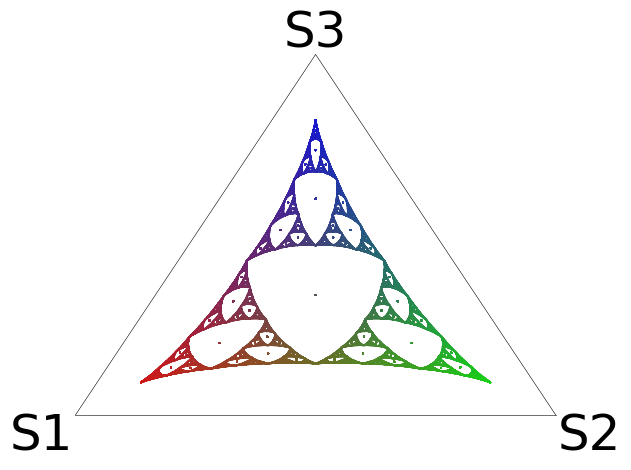

In [4]:
def plot_ground_truth_simplex(x, a):
    p = Mess3(x=x, a=a)
    msp = p.derive_mixed_state_presentation(9)
    probs, beliefs, paths = msp.collect_paths_with_beliefs()
    ground_truth = beliefs.reshape(-1, 3) @ TRIANGLE_PROJECTION
    colors = [tuple(b) for b in beliefs.reshape(-1, 3)]
    plt.scatter(ground_truth[:, 0], ground_truth[:, 1], s=.1, c=colors)
    for i in range(3):
        plt.plot([TRIANGLE_PROJECTION[i][0], TRIANGLE_PROJECTION[(i+1)%3][0]],
                 [TRIANGLE_PROJECTION[i][1], TRIANGLE_PROJECTION[(i+1)%3][1]],
                 'k-', linewidth=.4)
        
    # Label the vertices
    label_offsets = [(-0.07, -0.05), (0.07, -0.05), (0, 0.05)]  # Adjust these values as needed
    for i, (label, offset) in enumerate(zip(['S1', 'S2', 'S3'], label_offsets)):
        plt.annotate(label, 
                     xy=(TRIANGLE_PROJECTION[i][0], TRIANGLE_PROJECTION[i][1]),
                     xytext=(TRIANGLE_PROJECTION[i][0] + offset[0], TRIANGLE_PROJECTION[i][1] + offset[1]),
                     fontsize=36,
                     ha='center',
                     va='center')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_ground_truth_simplex(0.15, 0.6)


Total nodes generated: 29525


Processing Paths: 100%|██████████| 19683/19683 [00:06<00:00, 3164.35it/s]


Total nodes generated: 29525


Processing Paths: 100%|██████████| 19683/19683 [00:06<00:00, 3164.97it/s]


Total nodes generated: 29525


Processing Paths: 100%|██████████| 19683/19683 [00:06<00:00, 3180.88it/s]


Total nodes generated: 29525


Processing Paths: 100%|██████████| 19683/19683 [00:06<00:00, 3160.89it/s]


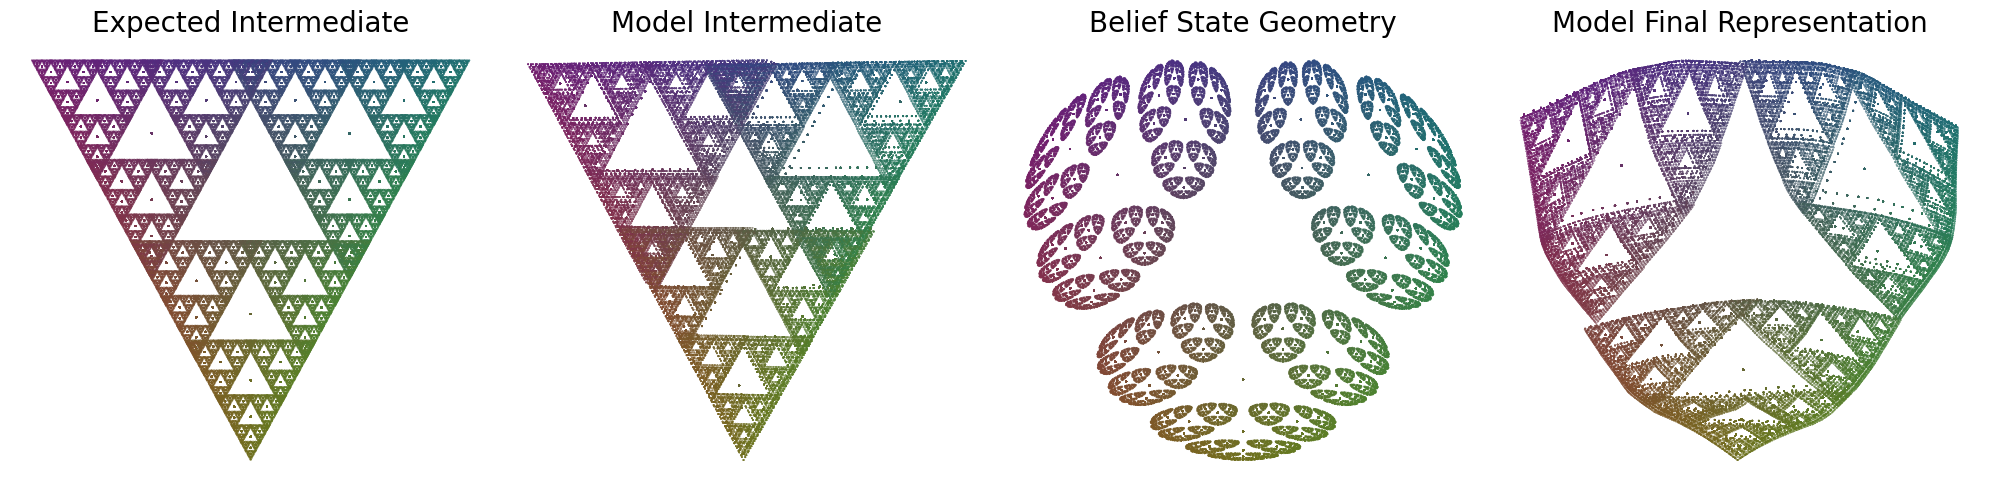

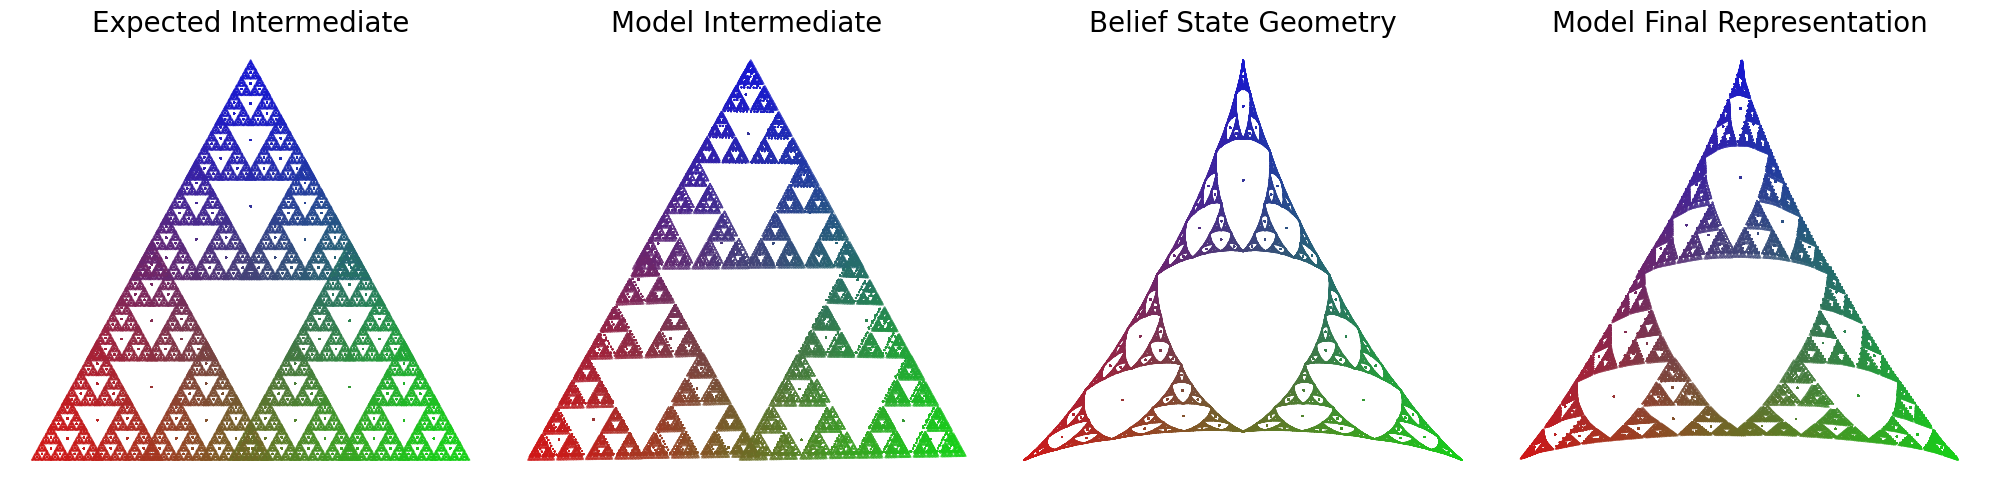

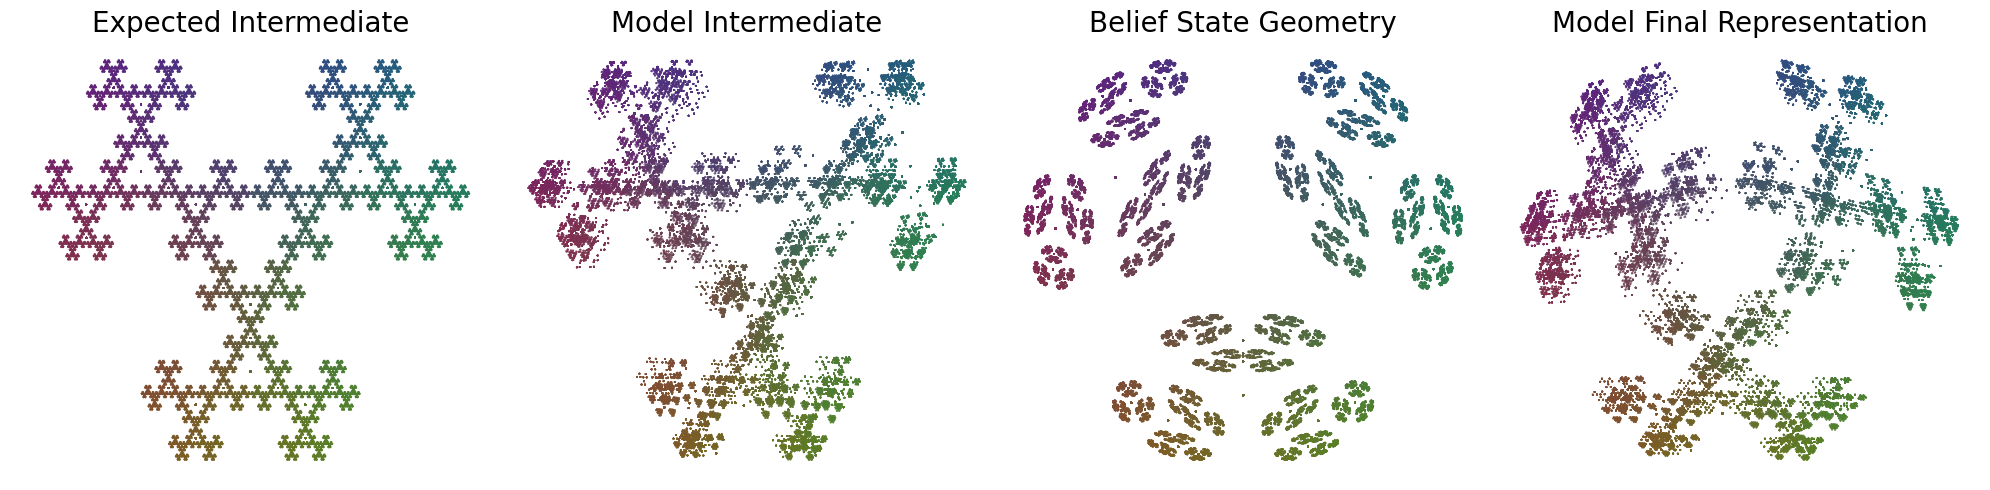

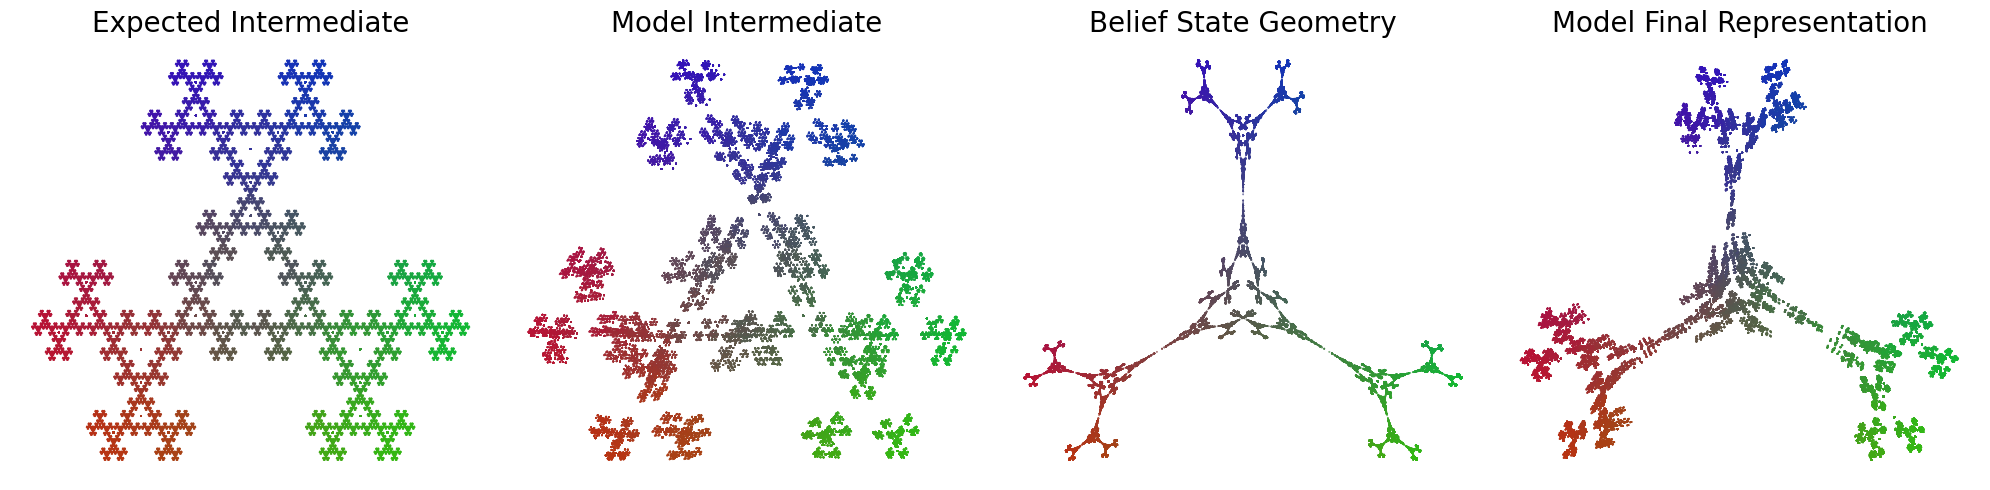

In [5]:
x_values = [0.15, 0.5]
a_values = [0.2, 0.6]

for idx, (x, a) in enumerate(itertools.product(x_values, a_values)):
    all_vecs, paths, beliefs = compute_all_vecs(x, a)
    ground_truth = all_vecs.reshape(-1, 3) @ TRIANGLE_PROJECTION
    colors = [tuple(b) for b in beliefs[:, 1:].reshape(-1, 3)]

    run = ExperimentRun(used_runs.loc[(x, a)])
    model = run.load_model()

    pca_resid_mid, pca_resid_post = run_pca_on_activations(model, separate_transformations=True, with_ln=True)
    reg, values = run_activation_to_beliefs_regression(pca_resid_mid[:, :, :3], all_vecs)
    values_proj = values.reshape(-1, 3) @ TRIANGLE_PROJECTION
    beliefs_proj = beliefs[:, 1:].reshape(-1, 3) @ TRIANGLE_PROJECTION

    reg_beliefs, beliefs_values = run_activation_to_beliefs_regression(pca_resid_post[:, :, :3], beliefs[:, 1:])
    beliefs_values_proj = beliefs_values.reshape(-1, 3) @ TRIANGLE_PROJECTION

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].scatter(ground_truth[:, 0], ground_truth[:, 1], s=.1, c=colors)
    axes[1].scatter(values_proj[:, 0], values_proj[:, 1], s=.1, c=colors)
    axes[2].scatter(beliefs_proj[:, 0], beliefs_proj[:, 1], s=.1, c=colors)
    axes[3].scatter(beliefs_values_proj[:, 0], beliefs_values_proj[:, 1], s=.1, c=colors)
    
    titles = [
        'Expected Intermediate', 
        'Model Intermediate',
        'Belief State Geometry',
        'Model Final Representation',
    ]
    for ax, title in zip(axes, titles):
        ax.set_title(title, fontsize=20)  # Increased font size for titles
        ax.axis('off')
        ax.set_frame_on(False)

    plt.tight_layout()


In [6]:
import numpy as np

x = 0.15
a = 0.6
all_vecs, paths, beliefs = compute_all_vecs(x, a)
ground_truth = all_vecs.reshape(-1, 3) @ TRIANGLE_PROJECTION
colors = [tuple(b) for b in beliefs[:, 1:].reshape(-1, 3)]

run = ExperimentRun(used_runs.loc[(x, a)])
model = run.load_model()
pca_resid_mid, pca_resid_post, pca_mid, pca_post = run_pca_on_activations(
    model, separate_transformations=True, with_ln=True, return_pcas=True
)

reg, values = run_activation_to_beliefs_regression(pca_resid_mid[:, :, :3], all_vecs)

W_E = model.W_E
W_pos = model.W_pos
block = model.blocks[0]
attn = block.attn

logits, cache = model.run_with_cache(sequences)

input_space = W_E[None].repeat(W_pos.shape[0], 1, 1) + W_pos[:, None].repeat(1, W_E.shape[0], 1)
VS = block.ln1(input_space) @ attn.W_V + attn.b_V
input_ov = VS @ attn.W_O + attn.b_O

diff = input_space[0, 0] + input_ov[0, 0] - cache["resid_mid", 0][0, 0]
max_diff = diff.abs().max()

assert max_diff < 1e-5

mean_pca = np.dot(pca_mid.mean_[None], pca_mid.components_.T)
pre_pca = pca_mid.transform(input_space.reshape(-1, model.cfg.d_model).cpu())[:, :3] + mean_pca[:, :3]
ov_pca = pca_mid.transform(input_ov.reshape(-1, model.cfg.d_model).cpu())[:, :3]
rotated_data = pca_resid_mid[:, :, :3]

pp = pre_pca.reshape(input_space.shape[0], -1, 3).swapaxes(0, 1)
op = ov_pca.reshape(input_ov.shape[0], -1, 3).swapaxes(0, 1)

tokens = pre_pca.reshape(10, 3, -1)
tokens_ov = ov_pca.reshape(10, 3, -1)
attn_pattern = cache['attn', 0, 'pattern'][:, 0].mean(0).cpu()


Total nodes generated: 29525


Processing Paths:   3%|▎         | 636/19683 [00:00<00:06, 3161.39it/s]

Processing Paths: 100%|██████████| 19683/19683 [00:06<00:00, 3161.60it/s]


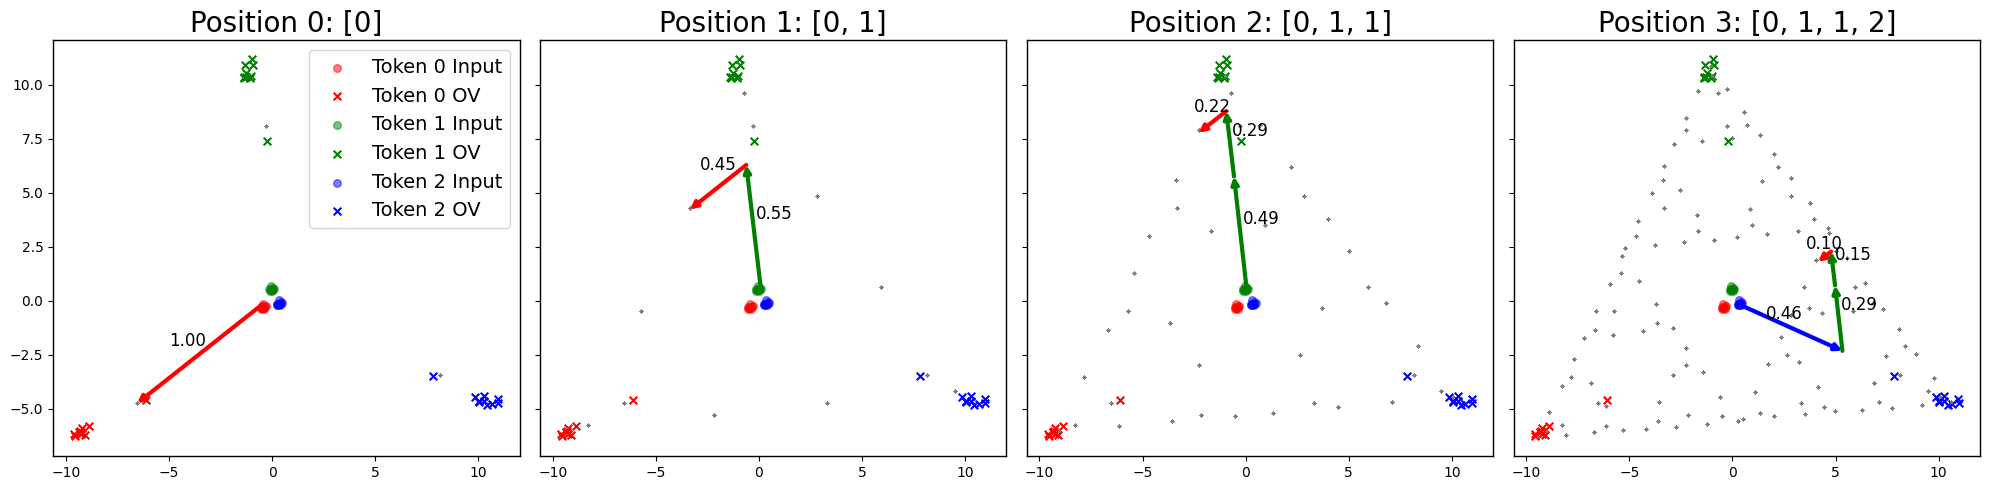

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), facecolor='white', sharey=True)
plt.style.use('default')

sequence = [0, 1, 1, 2]
colors = 'rgb'
size = 30

offets = [
    [(-.6, 0)],
    [(0, .4), (1, 0)],
    [(0, .1), (1, 0), (1, 0)],
    [(0, 0), (1, 0), (1, 0), (-.3, 0)],
]

for pos in range(4):
    ax = axs[pos]
    
    for i in range(pp.shape[0]):
        ax.scatter(pp[i, :, 0], pp[i, :, 1], alpha=0.5, s=size, c=[colors[i]], label=f'Token {i} Input')
        ax.scatter(op[i, :, 0], op[i, :, 1], alpha=1, s=size, c=[colors[i]], marker='x', label=f'Token {i} OV')

    rd = rotated_data[:, :pos+1, :3].reshape(-1, 3)
    ax.scatter(rd[:, 0], rd[:, 1], alpha=0.05, s=2, c="gray")

    tok_next = tok_0 = tokens[pos, sequence[pos]]
    for i, tok in reversed(list(enumerate(sequence[:pos + 1]))):
        tok_0 = tok_next
        tok_next = tok_0 + tokens_ov[i, tok] * attn_pattern[pos, i].item()

        attn_value = attn_pattern[pos, i].item()
        midpoint = ((tok_next[0] + tok_0[0]) / 2, (tok_next[1] + tok_0[1]) / 2)

        ax.annotate(
            '',
            xy=(tok_next[0], tok_next[1]),
            xytext=(tok_0[0], tok_0[1]),
            arrowprops=dict(
                arrowstyle='->',
                color=colors[tok],
                lw=3,
                shrinkA=0,
                shrinkB=0,
            ),
        )
        point = midpoint
        point = (point[0] + offets[pos][i][0], point[1] + offets[pos][i][1])

        ax.annotate(
            f'{attn_value:.2f}',
            xy=point,
            xytext=(0, 3),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=12,
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0)
        )

    ax.set_facecolor('white')
    ax.axis('on')
    ax.set_title(f"Position {pos}: {sequence[:pos+1]}", fontsize=20)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    if pos == 0:
        ax.legend(loc='upper right', fontsize=14)

plt.tight_layout()

In [8]:
run = ExperimentRun(used_runs.loc[(.5, .6)])
model = run.load_model()

W_E = model.W_E
W_pos = model.W_pos
block = model.blocks[0]
attn = block.attn

input_space = W_E[None].repeat(W_pos.shape[0], 1, 1) + W_pos[:, None].repeat(1, W_E.shape[0], 1)

VS1 = block.ln1(input_space) @ attn.W_V[0] + attn.b_V[0]
VS2 = block.ln1(input_space) @ attn.W_V[1] + attn.b_V[1]

input_ov1 = VS1 @ attn.W_O[0] + attn.b_O
input_ov2 = VS2 @ attn.W_O[1] + attn.b_O

# input_ov1.shape, input_ov2.shape
input_ov = torch.cat([input_ov1, input_ov2], dim=0)

In [9]:
_, _, pca_mid, pca_post = run_pca_on_activations(model, separate_transformations=True, with_ln=True, return_pcas=True)
mean_pca = np.dot(pca_mid.mean_[None], pca_mid.components_.T)
pre_pca = pca_mid.transform(input_space.reshape(-1, model.cfg.d_model).cpu())[:, :3] + mean_pca[:, :3]
ov_pca = pca_mid.transform(input_ov.reshape(-1, model.cfg.d_model).cpu())[:, :3]

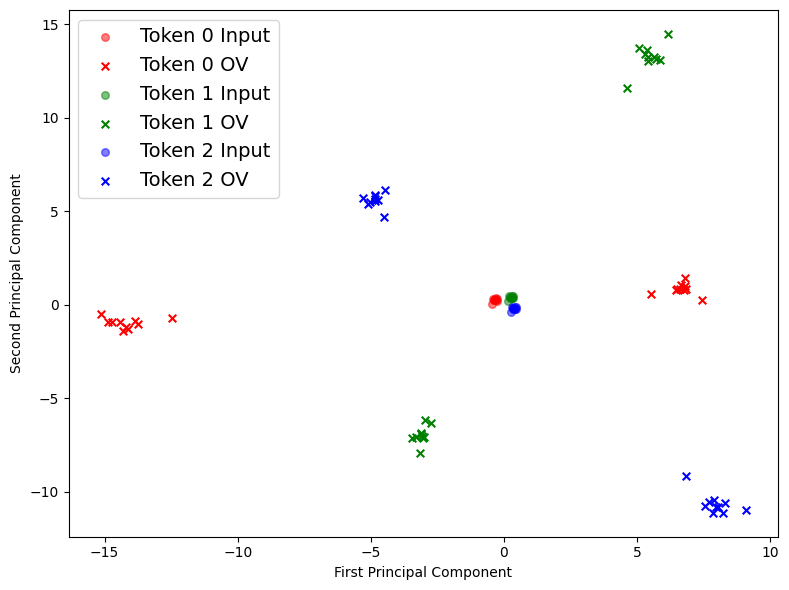

In [10]:
pp = pre_pca.reshape(input_space.shape[0], -1, 3).swapaxes(0, 1)
op = ov_pca.reshape(input_ov.shape[0], -1, 3).swapaxes(0, 1)

colors = 'rgb'
size = 30
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(pp.shape[0]):
    ax.scatter(pp[i, :, 0], pp[i, :, 1], alpha=0.5, s=size, c=[colors[i]], label=f'Token {i} Input')
    ax.scatter(op[i, :, 0], op[i, :, 1], alpha=1, s=size, c=[colors[i]], marker='x', label=f'Token {i} OV')

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend(loc='best', fontsize=14)
plt.tight_layout()


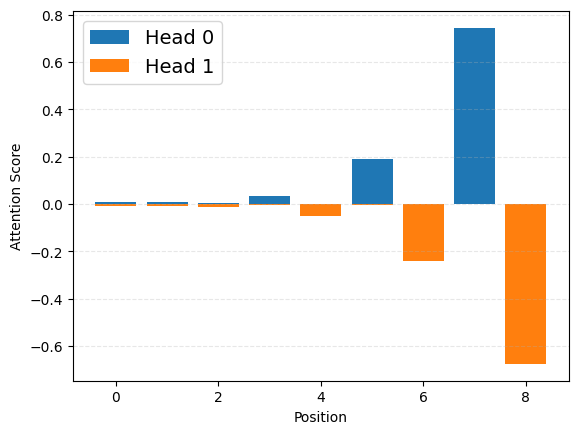

In [11]:
_, cache = model.run_with_cache(sequences)
d = cache['attn', 0, 'pattern'].mean(0)[:, -1].cpu()
d_neg = -d[1:]  
d = torch.cat([d_neg, d[:1]]) * -1

# plt.figure(figsize=(6, 6))
plt.bar(range(len(d[0])), d[0], label='Head 0')
plt.bar(range(len(d[0])), d[1], label='Head 1')
# plt.title('Attention Pattern')
plt.xlabel('Position')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylabel('Attention Score')
plt.legend(fontsize=14)

In [13]:
x_values = [0.15, 0.5]
a_values = [0.2, 0.6]

results = []

for idx, (x, a) in enumerate(itertools.product(x_values, a_values)):
    run = ExperimentRun(used_runs.loc[(x, a)])
    model = run.load_model()
    _, cache = model.run_with_cache(sequences)

    pca_resid_mid, pca_resid_post, pca_mid, pca_post = run_pca_on_activations(
        model,
        separate_transformations=True,
        sequences=sequences,
        with_ln=False,
        return_pcas=True,
    )

    var_explained_mid = pca_mid.explained_variance_ratio_
    var_explained_post = pca_post.explained_variance_ratio_

    _, pca_combined = run_pca_on_activations(
        model,
        separate_transformations=False,
        sequences=sequences,
        with_ln=False,
        return_pcas=True,
    )

    var_explained_combined = pca_combined.explained_variance_ratio_

    for i in range(10):
        result = {
            "x": x,
            "a": a,
            "component": i,
            "var_explained_mid": var_explained_mid[i],
            "cumulative_var_mid": np.cumsum(var_explained_mid)[i],
            "var_explained_post": var_explained_post[i],
            "cumulative_var_post": np.cumsum(var_explained_post)[i],
            "var_explained_combined": var_explained_combined[i],
            "cumulative_var_combined": np.cumsum(var_explained_combined)[i],
        }
        results.append(result)

df_results = pd.DataFrame(results)
df_results.pivot_table(
    index="component",
    columns=["x", "a"],
    values=["var_explained_mid", "var_explained_post"],
)

var_explained_mid                               var_explained_post  \
x                      0.15                0.50                         0.15   
a                       0.2       0.6       0.2       0.6                0.2   
component                                                                      
0                  0.540824  0.464821  0.526818  0.407434           0.961751   
1                  0.335987  0.424535  0.325131  0.395336           0.020787   
2                  0.090449  0.096593  0.065309  0.088534           0.011715   
3                  0.007608  0.004341  0.047665  0.054180           0.001724   
4                  0.006582  0.002573  0.023660  0.039304           0.000963   
5                  0.005530  0.001375  0.009103  0.012980           0.000645   
6                  0.004375  0.001296  0.000667  0.000872           0.000520   
7                  0.002830  0.001279  0.000636  0.000375           0.000442   
8                  0.002143  0.001101  0.000358  0.000265           0.000209   
9                  0.001330  0.000864  0.000268  0.000218           0.000184   

                                         
x                        0.50            
a               0.6       0.2       0.6  
component                                
0          0.494733  0.650301  0.459647  
1          0.273414  0.208912  0.249960  
2          0.212961  0.109643  0.175935  
3          0.008635  0.006639  0.033400  
4          0.001869  0.005181  0.023830  
5          0.001527  0.004310  0.015865  
6          0.001399  0.003621  0.013633  
7          0.001287  0.002247  0.006932  
8          0.000718  0.002119  0.004640  
9          0.000584  0.001492  0.003346